# Relevance vector machine

- The method of relevant vectors (RVM, Relevance vector machine) represent itself a classification and regression recovery algorithm based on Bayesian inference.
- This method uses a generalized linear model with regularization, which, in Bayesian interpretation, is equivalent to the introduction of parameters prior distributions.
- The main feature is that all parameters are regularized independently.

In [4]:
import numpy as np
import tqdm
from matplotlib import pyplot as plt
from __future__ import print_function

%matplotlib inline
np.random.seed(1234)

def l2_error(X, t, w):
    return np.sum((X.dot(w.ravel()) - t) ** 2)

## Model

Let's consider a sample $(\mathbf{X}, \mathbf{t}) = \{X_i, t_i\}_{i=1}^N$, where $x$ is a feature vector, $t$ is a target.
For each new object $x^*$ we need to predict $t^*$.

We assume, that
$$t=f(\mathbf{x})+\varepsilon,\ \varepsilon \sim \mathcal{N}(0, \sigma^2)$$
$$f(\mathbf{x}) = \sum_{j=1}^m \omega_j\phi_j(\mathbf{x}) = \mathbf{\omega}^T\mathbf{\phi}(\mathbf{x})$$

We estimate $w$ by maximizing posterior density
   $$\mathbf{\omega}_{MP} = \arg\,\max_{\mathbf{\omega}}\,\,p(\mathbf{\omega} |X,\mathbf{t}) = \arg\,\max_{\mathbf{\omega}} \,\,p(\mathbf{t} |X,\mathbf{\omega}) p(\mathbf{\omega})$$
  We assume that $\mathbf{\omega}$ has a normal distribution with a diagonal covariance matrix with different elements on the diagonal.
  $$p(\omega|\mathbf{\alpha}) = \mathcal{N}(0, A^{-1}),\  A=\mbox{diag}\,(\alpha_1,\ldots,\alpha_m)$$

## Formulas inference

For updating $\mathbf{w}$ and $\sigma$ we use the maximal evidence method
  $$p(\mathbf{t} |X,\mathbf{\alpha} ,\sigma^2) = \int p(\mathbf{t} |X,\mathbf{\omega}, \sigma^2)p(\mathbf{\omega} |\mathbf{\alpha} )d\mathbf{\omega} \to \max_{\mathbf{\alpha}, \sigma^2}$$
  
Let $Q(\mathbf{\omega}) = p(\mathbf{t} |X,\mathbf{\omega}, \sigma^2)p(\mathbf{\omega} |\mathbf{\alpha} ) \mbox{, }$
$L(\mathbf{\omega}) = \log Q(\mathbf{\omega})$  

Thus Q has normal distribution (normal distribution is selfadjoint distribution) $\Rightarrow$ L is quadratic function
$$L(\omega) = L(\omega_{MP}) + (\bigtriangledown_\omega L(\omega_{MP}))^T (\omega - \omega_{MP}) + \frac{1}{2}(\omega - \omega_{MP})^T H(\omega - \omega_{MP})$$

$\mathbf{\omega_{MP}} = \arg \max_\omega L(\omega)$ $\Rightarrow$ $\bigtriangledown_\omega L(\omega_{MP}) = 0$

$H = \bigtriangledown\bigtriangledown\,\log Q(\mathbf{\omega}_{MP})$,  

So

$$\int Q( \mathbf{\omega} )d\mathbf{\omega} = \int \exp {\Big(L(\omega_{MP}) + \frac{1}{2}(\omega - \mathbf{\omega_{MP}})^T H(\omega - \omega_{MP})\Big)d\mathbf{\omega}} = \sqrt{\left(2\pi\right)^m}\frac{Q(\mathbf{\omega} _{MP})}{\sqrt{\det(-H)}}$$

Let's define $\beta=\sigma^{-2}$

It can be shown,
$$L(\mathbf{\omega_{MP}}) =  \left( -\frac{1}{2}\mathbf{t}^T \left( \beta^{-1} I + \Phi A ^{-1} \Phi^T \right)^{-1} \mathbf{t} \right)$$

$$-H = \beta^{-1} I + \Phi A ^{-1} \Phi^T$$

So

$$p(\mathbf{t} |X,\mathbf{\alpha} ,\sigma^2) = \frac{1}{\sqrt{\left(2\pi\right)^m \det\left(\beta^{-1}I+\Phi A ^{-1}\Phi^T \right) }}\exp\left( -\frac{1}{2}\mathbf{t}^T \left( \beta^{-1} I + \Phi A ^{-1} \Phi^T \right)^{-1} \mathbf{t} \right)$$
	
where $\Phi$ is a matrix of generalized features

## Iteration formulas:

We obtain these formulas by equating to zero the derivatives by $\alpha$ and $\beta$ of the evidence function
$$\alpha_i^{new} = \frac{\gamma_i}{\omega^2_{MP,i}}$$ 
$$\gamma_i = \alpha_i^{old}\Sigma_{ii}$$
$$\beta_i^{new} = \frac{n-\sum_{i=1}^m\gamma_i}{{\parallel \mathbf{t} - \Phi\mathbf{\omega} \parallel}^2} \omega^2_{MP,i}$$ 		
where $$\Sigma = \left( \beta\Phi^T\Phi+A\right)^{-1}\mbox{, }\; \mathbf{\omega}_{MP} = \beta\Sigma\Phi^T\mathbf{t}$$

## Implementation

3 functions were realized

1. `get_w_sigma(X, t, alpha, beta)`: the function gets dataset $(X, t)$ and RVR hyperparameters ($\alpha$, $\beta$) and returns a posterior parameter distribution of $\mu$, $\Sigma$
2. `update_alpha_beta(X, t, alpha, beta)`: the function gets dataset $(X, t)$ and RVR hyperparameters ($\alpha$, $\beta$) and makes one iteration step to update alpha and beta
3. `fit_rvr(X, t, max_iters)`: the function gets dataset (X, t) and the number of maximum iteration and returns fitted hyperparameters and a posterior distribution to model weights

Implementation details:

1. Function get_w_sigma is often called with the same $X$, $t$, so we would use cached $X^T X$ and $X^T t$ for better perfomance
2. Function inf_inverse is used for inverse matrix X with correct infinity processing. Matrix inversing is also effective: it inverse submatrix with no infinities on diagonal

In [5]:
import scipy.linalg as sla

In [6]:
alpha_bound = 1e12
w_eps = 1e-50

def inf_inverse(X):
    res = np.zeros(X.shape)
    not_inf_mask = np.array([np.diag(X) != np.inf])
    not_inf = np.where(not_inf_mask[0])[0]
    inv = sla.inv(X[not_inf][:, not_inf]).ravel()
    res[np.where(not_inf_mask.T.dot(not_inf_mask))] = inv
    return res

def get_w_sigma(X, t, alpha, beta):
    """Calculate the mean and the covariance matrix
       of the posterior distribution"""
    if (not hasattr(get_w_sigma, 'cached_xtx') or \
        not np.array_equal(get_w_sigma.cached_xtx[0], X) or \
        not np.array_equal(get_w_sigma.cached_xtt[0], t)):
        get_w_sigma.cached_xtx = (X, X.T.dot(X))
        get_w_sigma.cached_xtt = (t, X.T.dot(t))
    n, d = X.shape
    sigma = inf_inverse(beta * get_w_sigma.cached_xtx[1] + np.diag(alpha))
    w = beta * sigma.dot(get_w_sigma.cached_xtt[1])
    return w, sigma


def update_alpha_beta(X, t, alpha, beta, flag):
    """Update the hyperperemeters to increase evidence"""
    n, d = X.shape
    w, sigma = get_w_sigma(X, t, alpha, beta)
    bad_value = alpha > alpha_bound
    w = np.where(bad_value, 0, w)
    alpha[bad_value] = 0
    gamma = np.where(bad_value, 0, 1 - alpha * np.diag(sigma))
    alpha_new = np.where(bad_value, np.inf, gamma / (w + w_eps) ** 2)
    beta_new = (n - gamma.sum()) / ((t - X.dot(w)) ** 2).sum()
    
    return alpha_new, beta_new


def fit_rvr(X, t, max_iter=10000):
    """Train the Relevance Vector Regression model"""
    n, d = X.shape
    alpha = np.ones(d)
    beta = 1
    for i in tqdm.tqdm(range(max_iter)):
        w, sigma = get_w_sigma(X, t, alpha, beta)
        alpha, beta = update_alpha_beta(X, t, alpha, beta, i == 2)
    return w, sigma, alpha, beta

## Regression with RBF features

We predict noisy function $sinc(x)$ $$sinc(x) = \frac{sin(\pi x)} {\pi x}$$
Dataset has 500 samples
$$t_i = sinc(x_i) + \mathcal{N}(0, \beta)$$
where $\beta=1 / 100$. 

We don't know $\beta$, it's used only for sample generation.
		
We would apply kernel trick: using RBF-transform of $X$ as $\Phi$:
$$\Phi_i(x) = \exp{(-\gamma||x - x_i||^2)}$$ where $x_i$ $-$ is samples from train data

We would compare SVR (support vector regression), L1-regression (lasso) and RVR.

/home/ekondranin/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


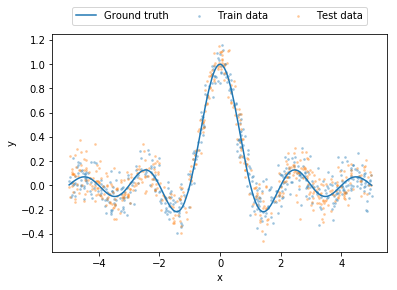

In [7]:
from sklearn.metrics.pairwise import rbf_kernel

# Data generation
def gen_batch(n, beta):
    points = np.random.uniform(-5, 5, n)
    points = np.sort(points)
    t = np.sinc(points) + np.random.normal(size=n) / beta ** 0.5
    return points, t

n = 500
d = n + 1
beta_true = 100

points_train, t_train = gen_batch(n, beta_true)
points_test, t_test = gen_batch(n, beta_true)

# RBF-transform
X_train = rbf_kernel(points_train.reshape(-1, 1), points_train.reshape(-1, 1))
X_test = rbf_kernel(points_test.reshape(-1, 1), points_train.reshape(-1, 1))

# Constant feature
X_train = np.hstack((np.ones((n, 1)), X_train))
X_test = np.hstack((np.ones((n, 1)), X_test))

# Visualization
plt.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
plt.plot(points_train, np.sinc(points_train), label='Ground truth')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [8]:
# Relevance Vector Regression
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train, max_iter=30000)

100%|██████████| 30000/30000 [04:23<00:00, 113.67it/s]


In [9]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=10, alphas=10.**np.arange(-6, 3, 1),
                fit_intercept=False).fit(X_train, t_train)
w_lasso = lasso.coef_

/home/ekondranin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ekondranin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [10]:
# Support Vector Regression
from sklearn.svm import SVR
svr = SVR(gamma=1, tol=1e-6, C=1).fit(points_train.reshape(-1, 1), t_train)

Relevance Vector Regression
Objects remaining: 12 / 500
Train error: 0.00920125703873
Test error:  0.0102011963648
--------------------------------------------------
Lasso Regression
Objects remaining: 147 / 500
Train error: 0.00921372547493
Test error:  0.0102170899357
--------------------------------------------------
Support Vector Regression
Objects remaining: 161 / 500
Train error: 0.00922904642811
Test error:  0.010466706152


/home/ekondranin/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


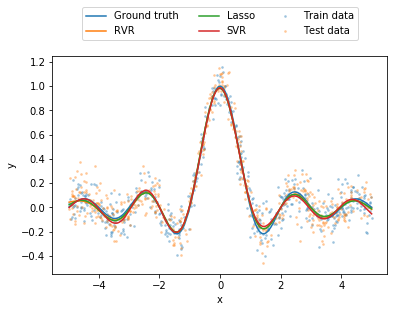

In [11]:
# Comparison
print('Relevance Vector Regression')
print('Objects remaining:', np.sum(alpha_rvr[1:] < 1e8), '/', n)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Lasso Regression')
print('Objects remaining:', np.sum(np.abs(w_lasso[1:]) > 1e-20), '/', n)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)
print('-'*50)
print('Support Vector Regression')
print('Objects remaining:', len(svr.support_), '/', n)
print('Train error:', np.sum((svr.predict(points_train.reshape(-1, 1)) - t_train) ** 2) / n)
print('Test error: ', np.sum((svr.predict(points_test.reshape(-1, 1)) - t_test) ** 2) / n)

plt.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
plt.plot(points_train, np.sinc(points_train), label='Ground truth')
plt.plot(points_train, X_train.dot(w_rvr), label='RVR')
plt.plot(points_train, X_train.dot(w_lasso), label='Lasso')
plt.plot(points_train, svr.predict(points_train.reshape(-1, 1)), label='SVR')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

/home/ekondranin/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


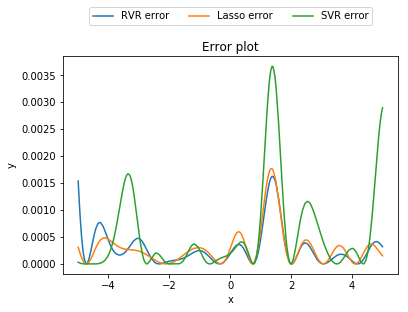

In [12]:
plt.title('Error plot')
plt.plot(points_train, (X_train.dot(w_rvr) - np.sinc(points_train)) ** 2, label='RVR error')
plt.plot(points_train, (X_train.dot(w_lasso) - np.sinc(points_train)) ** 2, label='Lasso error')
plt.plot(points_train, (svr.predict(points_train.reshape(-1, 1)) - np.sinc(points_train)) ** 2, label='SVR error')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

### Visualization of relevant objects

/home/ekondranin/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


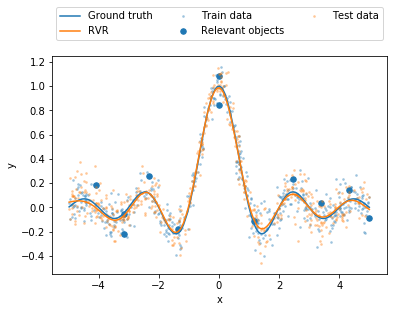

In [13]:
relevant = alpha_rvr[1:] < 1e8
plt.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(points_train[relevant], t_train[relevant], c='tab:blue', s=30, label='Relevant objects')
plt.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
plt.plot(points_train, np.sinc(points_train), label='Ground truth')
plt.plot(points_train, X_train.dot(w_rvr), label='RVR')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

## Сonclusions
It can be seen that in contrast to the other similar methods, the RVM method emits almost all features. However the quality of the model on the test sample remains comparable with other models, even a little better.

Advantages RVM over SVM:
1. It has much lower number of support vectors.
2. You need not find regularization hyperparameters
3. Noise emissions are not included in the support vectors

Also, similar to SVM, in RVM you can use kernels.